### PFA skin type and condition model partie 1 

In [1]:
import os
import json
import torch
import numpy as np
from PIL import Image
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
import matplotlib.pyplot as plt
from collections import defaultdict
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from sklearn.metrics import classification_report, confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
print(f"GPU name: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'No GPU'}")

PyTorch version: 2.5.1+cu121
CUDA available: True
CUDA version: 12.1
GPU name: NVIDIA GeForce RTX 4060 Laptop GPU


### check if the dataset is imbalaced or not

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),  
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.3),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.RandomErasing(p=0.5, scale=(0.02, 0.2)),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

def load_ds(name):
    return(os.path.join("C:/Users/salma/OneDrive/Documents/pfa/dataset",name).replace('\\','/') )
    
skin_type=load_ds('Skin-Types')  
skin_cond=load_ds('face_condition_split')



Class distribution for train set:
Class: dry, Samples: 652, Percentage: 23.66%
Class: normal, Samples: 1104, Percentage: 40.06%
Class: oily, Samples: 1000, Percentage: 36.28%
Imbalance ratio (max/min): 1.69
This set appears balanced (ratio <= 2).


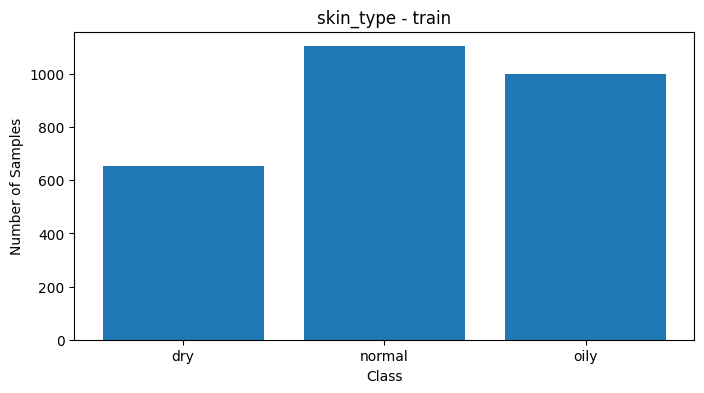


Class distribution for val set:
Class: dry, Samples: 71, Percentage: 27.10%
Class: normal, Samples: 111, Percentage: 42.37%
Class: oily, Samples: 80, Percentage: 30.53%
Imbalance ratio (max/min): 1.56
This set appears balanced (ratio <= 2).


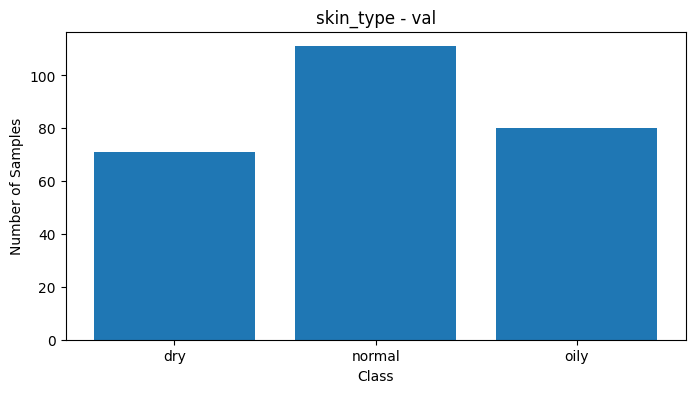


Class distribution for test set:
Class: dry, Samples: 35, Percentage: 26.12%
Class: normal, Samples: 59, Percentage: 44.03%
Class: oily, Samples: 40, Percentage: 29.85%
Imbalance ratio (max/min): 1.69
This set appears balanced (ratio <= 2).


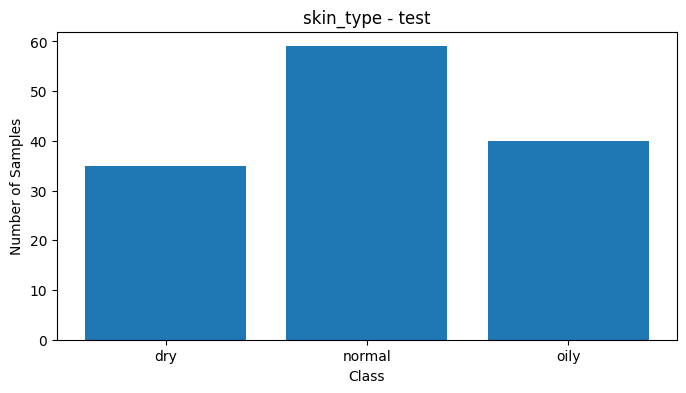


Class distribution for train set:
Class: Acne, Samples: 319, Percentage: 16.67%
Class: Carcinoma, Samples: 319, Percentage: 16.67%
Class: Eczema, Samples: 319, Percentage: 16.67%
Class: Keratosis, Samples: 319, Percentage: 16.67%
Class: Milia, Samples: 319, Percentage: 16.67%
Class: Rosacea, Samples: 319, Percentage: 16.67%
Imbalance ratio (max/min): 1.00
This set appears balanced (ratio <= 2).


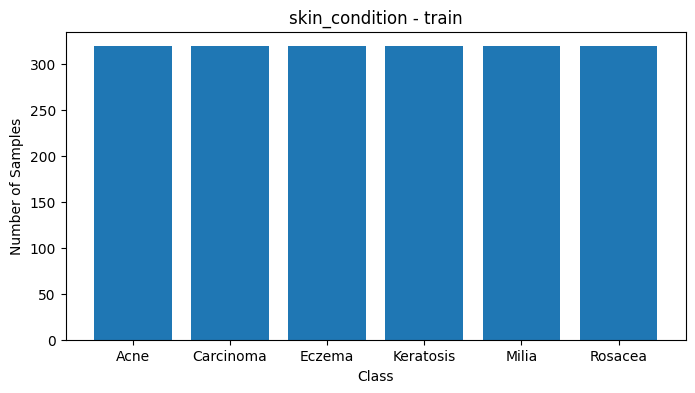


Class distribution for val set:
Class: Acne, Samples: 66, Percentage: 16.67%
Class: Carcinoma, Samples: 66, Percentage: 16.67%
Class: Eczema, Samples: 66, Percentage: 16.67%
Class: Keratosis, Samples: 66, Percentage: 16.67%
Class: Milia, Samples: 66, Percentage: 16.67%
Class: Rosacea, Samples: 66, Percentage: 16.67%
Imbalance ratio (max/min): 1.00
This set appears balanced (ratio <= 2).


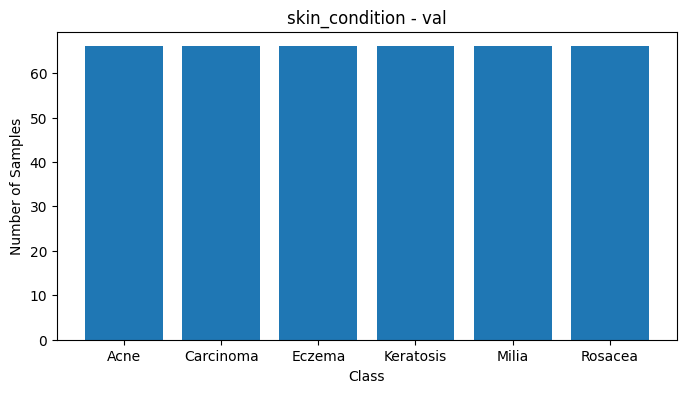


Class distribution for test set:
Class: Acne, Samples: 71, Percentage: 16.67%
Class: Carcinoma, Samples: 71, Percentage: 16.67%
Class: Eczema, Samples: 71, Percentage: 16.67%
Class: Keratosis, Samples: 71, Percentage: 16.67%
Class: Milia, Samples: 71, Percentage: 16.67%
Class: Rosacea, Samples: 71, Percentage: 16.67%
Imbalance ratio (max/min): 1.00
This set appears balanced (ratio <= 2).


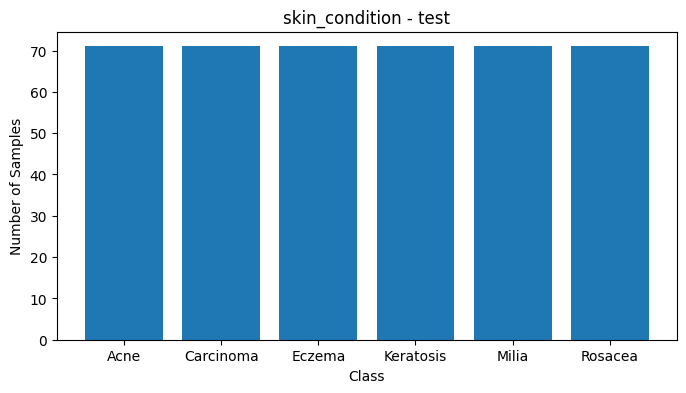

In [4]:
splits = ['train', 'val', 'test']
def count_samples_per_class(data_dir, split):
    class_counts = defaultdict(int)
    split_dir = os.path.join(data_dir, split) 
    for class_name in os.listdir(split_dir):
        class_path = os.path.join(split_dir, class_name)
        if os.path.isdir(class_path):
            num_samples = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f) )])
            class_counts[class_name] = num_samples
    
    return class_counts

def check_each_ds (data_dir,nameds):
    for split in splits:
        print(f"\nClass distribution for {split} set:")
        class_counts = count_samples_per_class(data_dir, split) 
        total_samples = sum(class_counts.values())
        for class_name, count in class_counts.items():
            percentage = (count / total_samples) * 100 if total_samples > 0 else 0
            print(f"Class: {class_name}, Samples: {count}, Percentage: {percentage:.2f}%")
        if class_counts:
            max_count = max(class_counts.values())
            min_count = min(class_counts.values())
            imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')
            print(f"Imbalance ratio (max/min): {imbalance_ratio:.2f}")
            if imbalance_ratio > 2:
                print("Warning: This set is imbalanced (ratio > 2).")
            else:
                print("This set appears balanced (ratio <= 2).")
        plt.figure(figsize=(8, 4))
        plt.bar(class_counts.keys(), class_counts.values())
        plt.title(f"{nameds} - {split}")
        plt.xlabel("Class")
        plt.ylabel("Number of Samples")
        plt.show()

check_each_ds(skin_type,'skin_type')
check_each_ds(skin_cond,'skin_condition')

### Building the model

In [5]:
def prepare_model(data_dir):
    image_datasets = {
        x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
        for x in splits
    }
    
    class_counts_dict = count_samples_per_class(data_dir, 'train')
    class_names = image_datasets['train'].classes
    print(f"Class names: {class_names}")
    print(f"Class counts: {class_counts_dict}")
    class_counts = [class_counts_dict[cls] for cls in class_names]
    if not class_counts or min(class_counts) == 0:
        raise ValueError("No samples found for one or more classes in the training set.")
        
    total = sum(class_counts)
    class_weights = [(total/count) ** 0.5 for count in class_counts]
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
    print(f"Class weights: {class_weights.tolist()}")

    train_targets = [sample[1] for sample in image_datasets['train'].samples]
    sample_weights = [class_weights[target].item() for target in train_targets]
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

    dataloaders = {
        'train': DataLoader(image_datasets['train'], batch_size=32, sampler=sampler, num_workers=8),
        'val': DataLoader(image_datasets['val'], batch_size=32, shuffle=False, num_workers=8),
        'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=False, num_workers=8)
    }
    dataset_sizes = {x: len(image_datasets[x]) for x in splits}
    num_classes = len(class_names)

    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    for param in model.parameters():
        param.requires_grad = False
    num_ftrs = model.fc.in_features
    model.fc= nn.Sequential(
        nn.Dropout(0.5),  
        nn.Linear(num_ftrs, num_classes)
    )
    model = model.to(device)

    print("\nModel Summary:")
    summary(model, input_size=(16, 3, 224, 224), device=str(device))

    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-4)
    return model, criterion, optimizer, dataloaders, dataset_sizes



### Training the model

In [6]:
def train_model(model, criterion, optimizer, dataloaders, dataset_sizes, num_epochs=20, patience=7):
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7)
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_wts = model.state_dict()
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            if phase == 'train':
                train_losses.append(epoch_loss)
            else:
                val_losses.append(epoch_loss)
                if epoch_loss < best_val_loss:
                    best_val_loss = epoch_loss
                    best_model_wts = model.state_dict()
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1
                scheduler.step(epoch_loss)
                if epochs_no_improve >= 7:
                    print(f'Early stopping at epoch {epoch+1}')
                    model.load_state_dict(best_model_wts)
                    
                    plt.figure(figsize=(20, 15))
                    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
                    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
                    plt.xlabel('Epoch')
                    plt.ylabel('Loss')
                    plt.title('Training and Validation Loss Curves')
                    plt.legend()
                    plt.grid(True)
                    plt.show()
                    return model
                    
    model.load_state_dict(best_model_wts)

    plt.figure(figsize=(20, 15))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return model

### Evaluation

In [7]:
def evaluate_model(model, dataloaders, dataset_sizes, phase='test'):
    model.eval()
    all_preds = []
    all_labels = []
    class_names = dataloaders[phase].dataset.classes

    with torch.no_grad():
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f'{phase} Accuracy: {accuracy:.4f}')

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)
    print("\nConfusion Matrix:")
    print(cm)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {phase}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


Class names: ['dry', 'normal', 'oily']
Class counts: defaultdict(<class 'int'>, {'dry': 652, 'normal': 1104, 'oily': 1000})
Class weights: [2.0559654235839844, 1.579992651939392, 1.6601204872131348]

Model Summary:
Epoch 1/30
----------
train Loss: 1.3783 Acc: 0.3302
val Loss: 1.0914 Acc: 0.3473
Epoch 2/30
----------
train Loss: 1.3478 Acc: 0.3298
val Loss: 1.0909 Acc: 0.4313
Epoch 3/30
----------
train Loss: 1.3039 Acc: 0.3527
val Loss: 1.1119 Acc: 0.4237
Epoch 4/30
----------
train Loss: 1.2797 Acc: 0.3483
val Loss: 1.1405 Acc: 0.3015
Epoch 5/30
----------
train Loss: 1.3073 Acc: 0.3218
val Loss: 1.1686 Acc: 0.2252
Epoch 6/30
----------
train Loss: 1.2849 Acc: 0.3338
val Loss: 1.1312 Acc: 0.2710
Epoch 7/30
----------
train Loss: 1.2736 Acc: 0.3389
val Loss: 1.1180 Acc: 0.3931
Epoch 8/30
----------
train Loss: 1.2379 Acc: 0.3360
val Loss: 1.1317 Acc: 0.3473
Epoch 9/30
----------
train Loss: 1.2322 Acc: 0.3429
val Loss: 1.1449 Acc: 0.2977
Early stopping at epoch 9


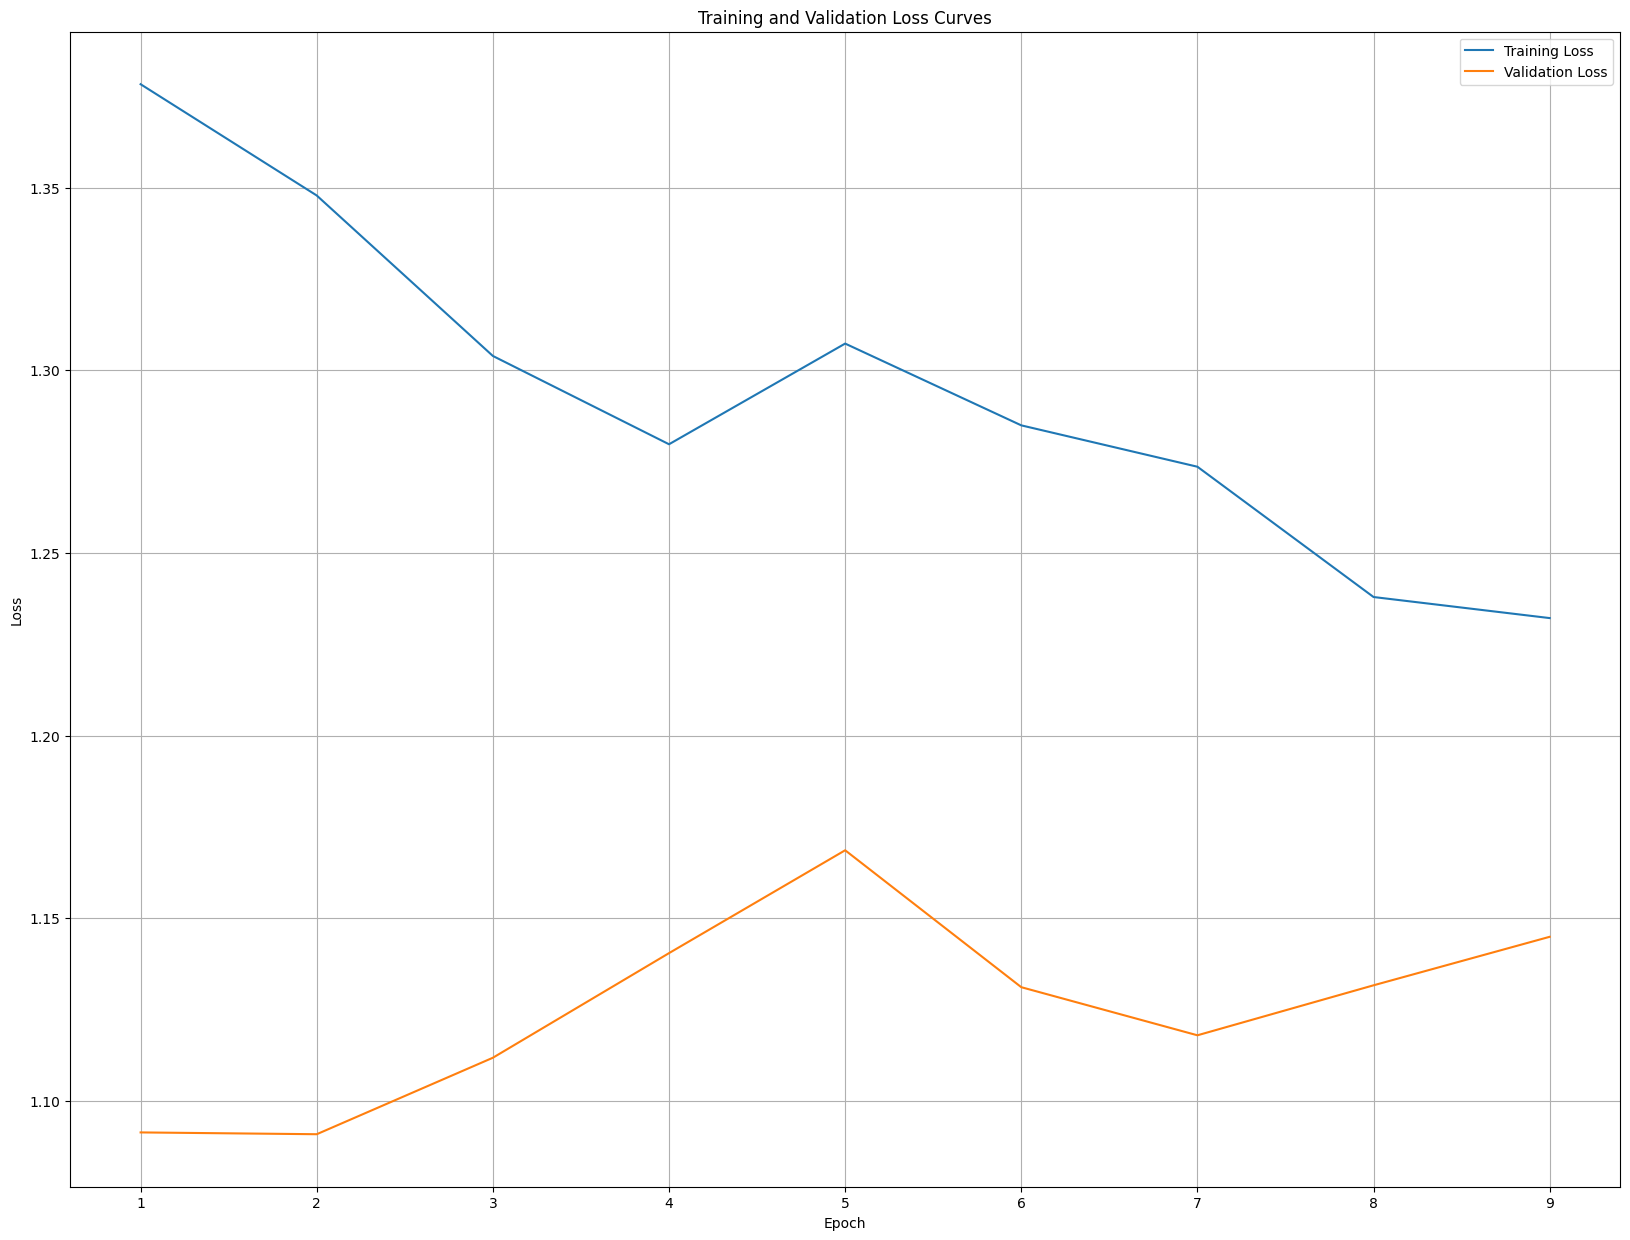

In [8]:
modeltype, criteriontype, optimizertype, dataloaderstype, dataset_sizestype= prepare_model(skin_type)
modeltype=train_model(modeltype, criteriontype, optimizertype, dataloaderstype, dataset_sizestype)

test Accuracy: 0.3657

Classification Report:
              precision    recall  f1-score   support

         dry       0.00      0.00      0.00        35
      normal       0.50      0.27      0.35        59
        oily       0.32      0.82      0.46        40

    accuracy                           0.37       134
   macro avg       0.27      0.37      0.27       134
weighted avg       0.32      0.37      0.29       134


Confusion Matrix:
[[ 0  9 26]
 [ 0 16 43]
 [ 0  7 33]]


C:\Users\salma\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\salma\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\salma\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

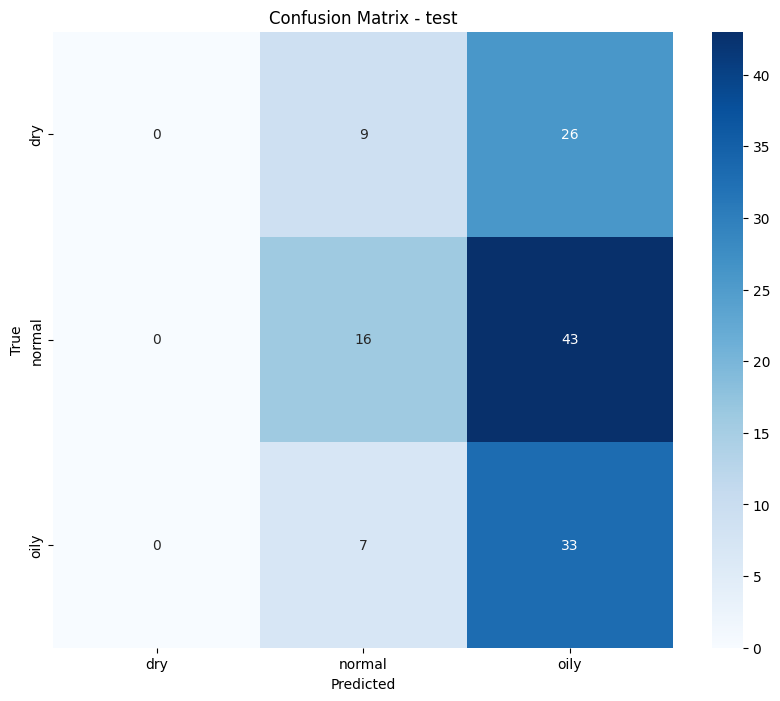

In [9]:
evaluate_model(modeltype, dataloaderstype, dataset_sizestype, phase='test')

Class names: ['Acne', 'Carcinoma', 'Eczema', 'Keratosis', 'Milia', 'Rosacea']
Class counts: defaultdict(<class 'int'>, {'Acne': 319, 'Carcinoma': 319, 'Eczema': 319, 'Keratosis': 319, 'Milia': 319, 'Rosacea': 319})
Class weights: [2.4494898319244385, 2.4494898319244385, 2.4494898319244385, 2.4494898319244385, 2.4494898319244385, 2.4494898319244385]

Model Summary:
Epoch 1/20
----------
train Loss: 2.0731 Acc: 0.1865
val Loss: 1.7819 Acc: 0.2045
Epoch 2/20
----------
train Loss: 2.0107 Acc: 0.2142
val Loss: 1.7524 Acc: 0.2576
Epoch 3/20
----------
train Loss: 1.9276 Acc: 0.2544
val Loss: 1.5850 Acc: 0.3712
Epoch 4/20
----------
train Loss: 1.7920 Acc: 0.3098
val Loss: 1.4476 Acc: 0.4343
Epoch 5/20
----------
train Loss: 1.7239 Acc: 0.3323
val Loss: 1.3797 Acc: 0.4394
Epoch 6/20
----------
train Loss: 1.6693 Acc: 0.3793
val Loss: 1.4209 Acc: 0.4495
Epoch 7/20
----------
train Loss: 1.6799 Acc: 0.3725
val Loss: 1.4119 Acc: 0.4949
Epoch 8/20
----------
train Loss: 1.5782 Acc: 0.3986
val Lo

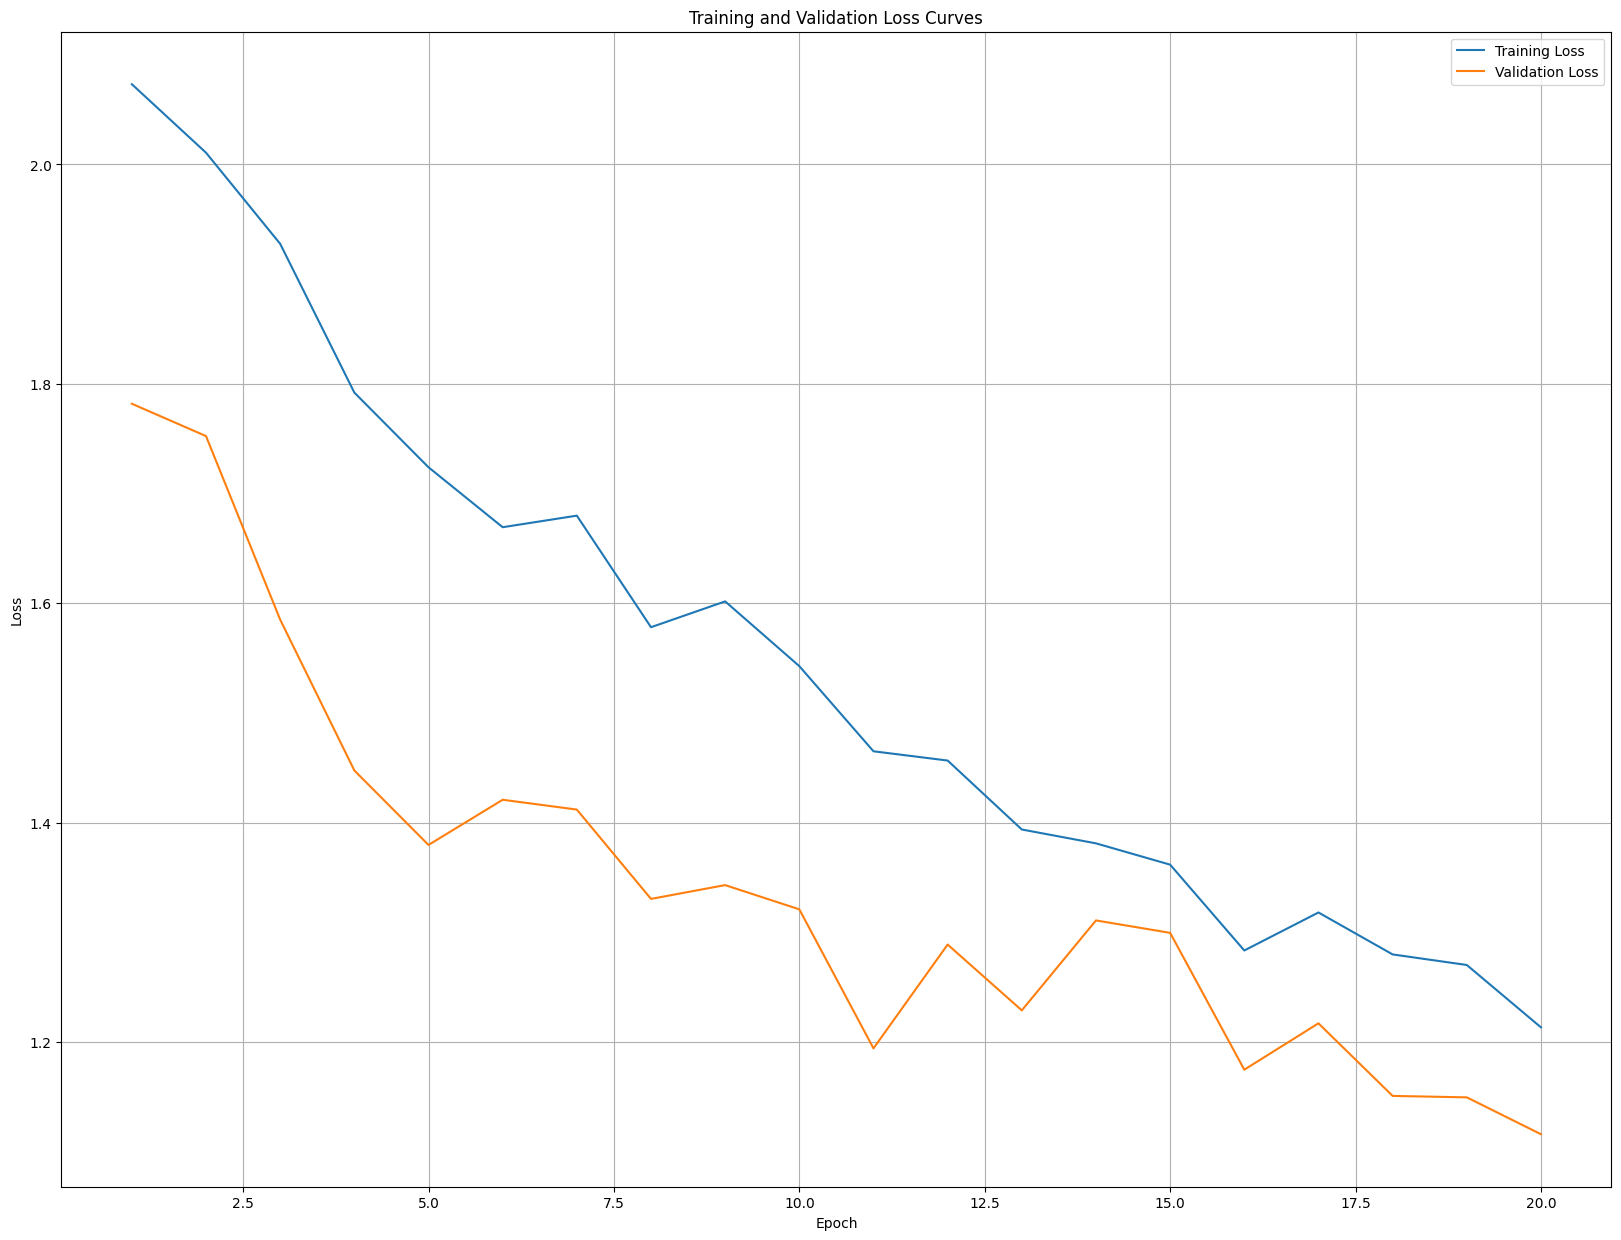

In [10]:
modelcond, criterioncond, optimizercond, dataloaderscond, dataset_sizescond= prepare_model(skin_cond)
modelcond=train_model(modelcond, criterioncond, optimizercond, dataloaderscond, dataset_sizescond, num_epochs=20)

test Accuracy: 0.6315

Classification Report:
              precision    recall  f1-score   support

        Acne       0.60      0.68      0.64        71
   Carcinoma       0.67      0.79      0.72        71
      Eczema       0.82      0.38      0.52        71
   Keratosis       0.63      0.77      0.70        71
       Milia       0.51      0.49      0.50        71
     Rosacea       0.65      0.68      0.66        71

    accuracy                           0.63       426
   macro avg       0.65      0.63      0.62       426
weighted avg       0.65      0.63      0.62       426


Confusion Matrix:
[[48  4  2  2  3 12]
 [ 1 56  2  4  6  2]
 [11  6 27  8 13  6]
 [ 0  6  0 55  8  2]
 [ 7  9  2 14 35  4]
 [13  3  0  4  3 48]]


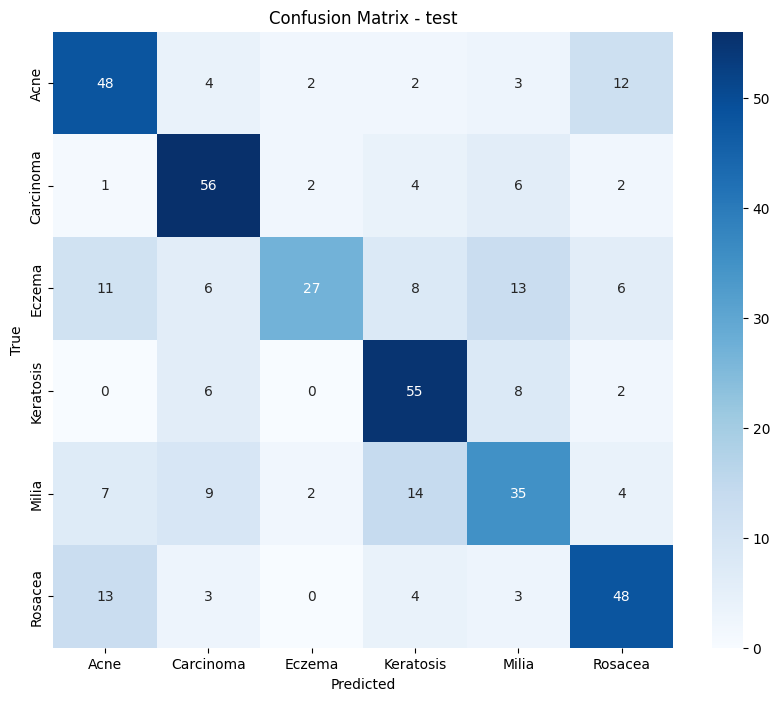

In [11]:
evaluate_model(modelcond, dataloaderscond, dataset_sizescond, phase='test')

In [12]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

class CustomImageDataset(Dataset):
    def __init__(self, image_path, transform=None, labeled=False):
        self.images = [image_path]
        self.transform = transform
        self.labeled = labeled
        self.labels = [0] if labeled else [] 

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        if self.labeled:
            return image, 0  
        return image

In [18]:
def test_single_image(model, image_path, transform, device='cpu', class_names=None):
    model.eval()
    model.to(device)
    image_path=image_path.replace('\\','/')
    
    dataset = CustomImageDataset(image_path, transform=transform, labeled=False)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

    with torch.no_grad():
        for image in dataloader:
            image = image.to(device)
            output = model(image)
            probabilities = torch.softmax(output, dim=1)
            predicted_class = torch.argmax(probabilities, dim=1).item()
            predicted_prob = probabilities[0, predicted_class].item()

    predicted_label = class_names[predicted_class] if class_names else predicted_class
    return predicted_label, predicted_prob

In [19]:
def save_model(model, optimizer, model_name):
    checkpoint = {
        'epoch': 20,  
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(checkpoint, f'{model_name}_checkpoint.pth')
    torch.save(model.state_dict(), f'{model_name}_weights.pth')
    torch.save(model, f'{model_name}_full_model.pth')

In [28]:
if __name__ == "__main__":
    modelcond.to(device)
    modeltype.to(device)

    cond_class_names = ['Acne', 'Carcinoma', 'Eczema', 'Keratosis', 'Milia', 'Rosacea']
    type_class_names = ['dry', 'normal', 'oily']

    image_path = 'C:/Users/salma/OneDrive/Documents/pfa/OIP.jpg'

    print("Saving models...")
    save_model(modelcond, optimizercond, 'skin_cond')
    save_model(modeltype, optimizertype, 'skin_type')

    print("\nTesting ...")
    cond_label, cond_prob = test_single_image(modelcond, image_path, data_transforms, device, cond_class_names)
    print(f"Predicted Skin Condition: {cond_label}")
    print(f"Condition Confidence: {cond_prob:.4f}")

    type_label, type_prob = test_single_image(modeltype, image_path, data_transforms, device, type_class_names)
    print(f"Predicted Skin Type: {type_label}")
    print(f"Type Confidence: {type_prob:.4f}")


Saving models...

Testing ...
Predicted Skin Condition: Milia
Condition Confidence: 0.3756
Predicted Skin Type: oily
Type Confidence: 0.3852
